<div align="center">
    <h1>Fraud credit card transaction recognition with Concrete ML</h1>
</div>

## Table of Contents
1. [Introduction](#introduction)
2. [Setup and Data Loading](#setup-and-data-loading)
3. [Exploratory Data Analysis (EDA)](#Exploratory-Data-Analysis)
    1. [Target Variable Distribution](#target-variable-distribution)
4. [Feature Correlations](#feature-correlations)
5. [Categorical features analysis](#categorical-features-analysis)
6. [Model Training and Evaluation](#model-training-and-evaluation)
7. [Results Analysis](#results-analysis)
8. [ROC Curve Plot](#roc-curve-plot)

## Introduction
In this notebook, we will analyze a dataset on credit card fraud detection. The dataset includes features such as distance from home, whether a transaction was made online or through a chip, and whether the transaction was fraudulent. Our goal is to identify the strengths and weaknesses of the dataset, perform preprocessing, and prepare the data for future model development.

## Setup and Data Loading
We will start by loading the required libraries and importing the dataset.


In [1]:
"""
Demo Notebook
"""

# Standard imports
import time
import os
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from IPython.display import display

# Third-party library imports
from sklearn.ensemble import RandomForestClassifier as SkRandomForestClassifier
from sklearn.linear_model import LogisticRegression as SkLogisticRegression
from sklearn.metrics import (
    accuracy_score,
    auc,
    roc_curve,
    precision_score,
    recall_score,
    f1_score,
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neural_network import MLPClassifier as SkMLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC as SkLinearSVC
from sklearn.tree import DecisionTreeClassifier as SkDecisionTreeClassifier
from xgboost import XGBClassifier as SkXGBClassifier

# Local or project-specific imports
from concrete.ml.deployment import FHEModelDev
from concrete.ml.sklearn.rf import RandomForestClassifier
from concrete.ml.sklearn.linear_model import LogisticRegression
from concrete.ml.sklearn.svm import LinearSVC
from concrete.ml.sklearn.tree import DecisionTreeClassifier
from concrete.ml.sklearn.xgb import XGBClassifier
from concrete.ml.sklearn import NeuralNetClassifier

In [2]:
DATA_PATH = os.path.join(
    os.path.abspath(os.getcwd()), "..", "dataset", "card_transdata.csv"
)

In [3]:
df = pd.read_csv(DATA_PATH)
df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB


## Exploratory Data Analysis


In [5]:
# Check for missing values
df.isnull().sum()

distance_from_home                0
distance_from_last_transaction    0
ratio_to_median_purchase_price    0
repeat_retailer                   0
used_chip                         0
used_pin_number                   0
online_order                      0
fraud                             0
dtype: int64

In [6]:
# Statistical overview of numerical columns
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
distance_from_home,1000000.0,26.628792,65.390784,0.004874,3.878008,9.967760,25.743985,10632.723672
distance_from_last_transaction,1000000.0,5.036519,25.843093,0.000118,0.296671,0.998650,3.355748,11851.104565
ratio_to_median_purchase_price,1000000.0,1.824182,2.799589,0.004399,0.475673,0.997717,2.096370,267.802942
repeat_retailer,1000000.0,0.881536,0.323157,0.000000,1.000000,1.000000,1.000000,1.000000
used_chip,1000000.0,0.350399,0.477095,0.000000,0.000000,0.000000,1.000000,1.000000
used_pin_number,1000000.0,0.100608,0.300809,0.000000,0.000000,0.000000,0.000000,1.000000
online_order,1000000.0,0.650552,0.476796,0.000000,0.000000,1.000000,1.000000,1.000000
fraud,1000000.0,0.087403,0.282425,0.000000,0.000000,0.000000,0.000000,1.000000


# Target Variable Distribution
We will start by checking the distribution of the target variable, fraud, to understand the class imbalance in the dataset.

In [7]:
df["fraud"].value_counts()

fraud
0.0    912597
1.0     87403
Name: count, dtype: int64

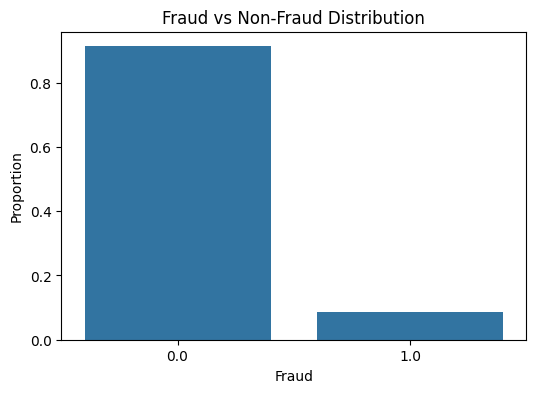

In [8]:
# Check for class imbalance
fraud_distribution = df["fraud"].value_counts(normalize=True)
plt.figure(figsize=(6, 4))
sns.barplot(x=fraud_distribution.index, y=fraud_distribution.values)
plt.title("Fraud vs Non-Fraud Distribution")
plt.xlabel("Fraud")
plt.ylabel("Proportion")
plt.show()

This dataset is highly imbalanced, we will need to balance it before training the model

In [9]:
fraud = df[df["fraud"] == 1]
no_fraud = df[df["fraud"] == 0].sample(n=len(fraud), random_state=42)
df_balanced = pd.concat([fraud, no_fraud])
df_balanced["fraud"].value_counts()

fraud
1.0    87403
0.0    87403
Name: count, dtype: int64

## Feature Correlations

To understand the relationships between the features, we’ll compute the correlation matrix and visualize it using a heatmap.

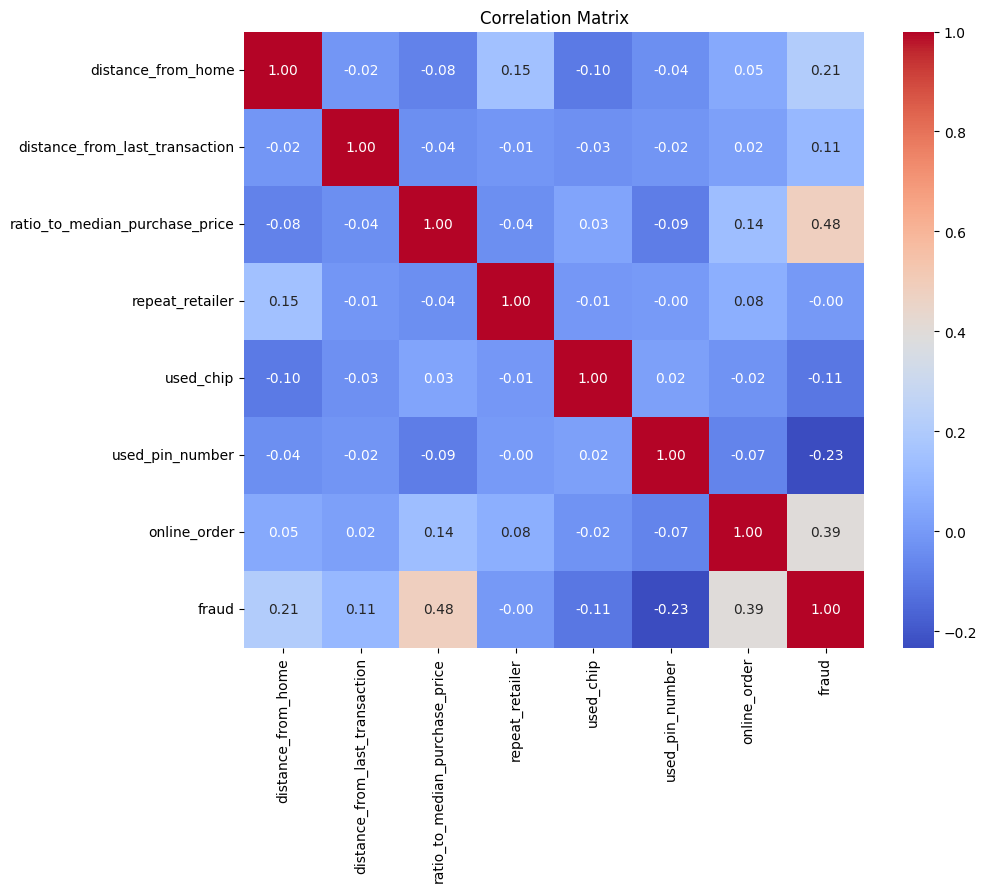

In [10]:
corr_matrix = df_balanced.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

## Categorical features analysis

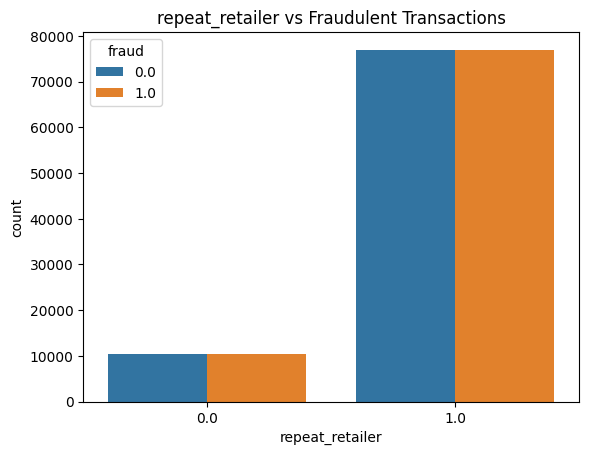

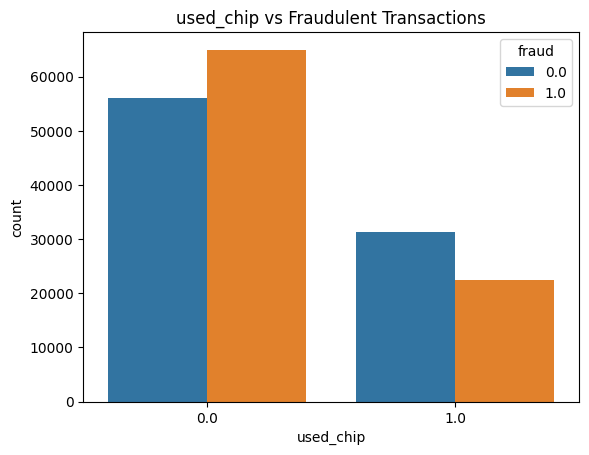

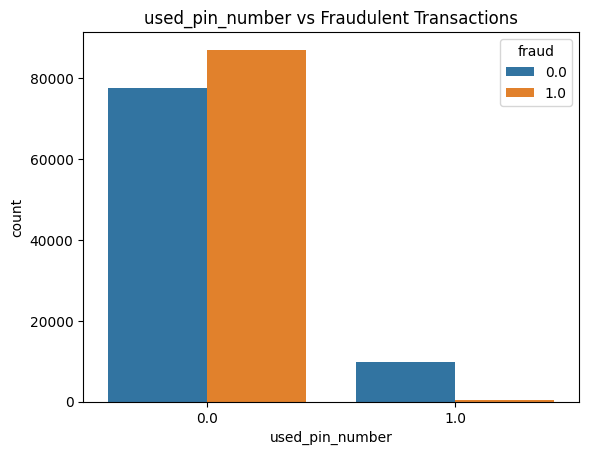

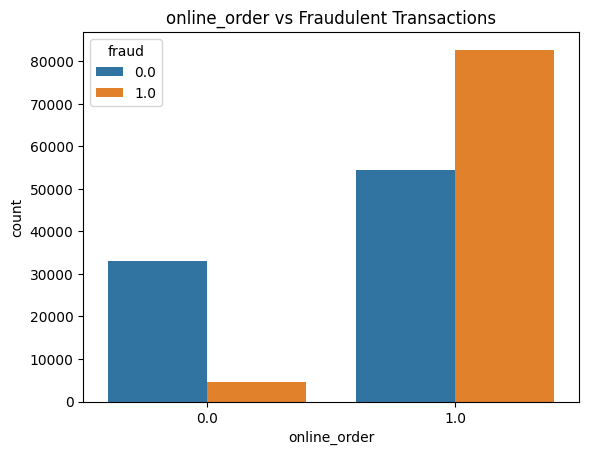

In [11]:
for feature in ["repeat_retailer", "used_chip", "used_pin_number", "online_order"]:
    sns.countplot(x=feature, hue="fraud", data=df_balanced)
    plt.title(f"{feature} vs Fraudulent Transactions")
    plt.show()

## Model Training and Evaluation
We will now train several machine learning models, including both traditional and FHE models, and evaluate their performance.

In [12]:
# Train-Test Split
X = df_balanced.drop(columns=["fraud"])
y = df_balanced["fraud"]

In [13]:
# Split the data into training, validation, and testing sets
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

In [14]:
# Feature Scaling
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.transform(x_val)
x_test_scaled = scaler.transform(x_test)

In [15]:
# Check the shape of the data
print(f"x_train shape: {x_train_scaled.shape}")
print(f"x_val shape: {x_val_scaled.shape}")
print(f"x_test shape: {x_test_scaled.shape}")

x_train shape: (111875, 7)
x_val shape: (27969, 7)
x_test shape: (34962, 7)


In [16]:
print(y_train.value_counts(normalize=True))
print(y_val.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

fraud
1.0    0.500004
0.0    0.499996
Name: proportion, dtype: float64
fraud
0.0    0.500018
1.0    0.499982
Name: proportion, dtype: float64
fraud
0.0    0.5
1.0    0.5
Name: proportion, dtype: float64


In [ ]:
# Models to compare
models = {
    "Random Forest": (
        SkRandomForestClassifier(n_estimators=100, random_state=42),
        RandomForestClassifier(n_estimators=100, random_state=42),
    ),
    "Logistic Regression": (
        SkLogisticRegression(max_iter=1000, random_state=42),
        LogisticRegression(max_iter=1000, random_state=42),
    ),
    "Decision Tree": (
        SkDecisionTreeClassifier(random_state=42),
        DecisionTreeClassifier(random_state=42),
    ),
    "Linear SVC": (SkLinearSVC(random_state=42), LinearSVC(random_state=42)),
    "XGBoost Classifier": (
        SkXGBClassifier(random_state=42, use_label_encoder=False),
        XGBClassifier(random_state=42, use_label_encoder=False),
    ),
    "Neural Networks Classifier": (
        SkMLPClassifier(
            hidden_layer_sizes=(50, 50),
            max_iter=50,
            random_state=42,
            batch_size=128,
            learning_rate_init=0.001,
        ),
        NeuralNetClassifier(
            module__n_layers=2, max_epochs=50, batch_size=128, lr=0.001
        ),
    ),
}


def train_and_evaluate_models(training_data, training_labels, val_data, val_labels):
    """
    Train and evaluate all models
    """
    training_labels = training_labels.astype(int)
    val_labels = val_labels.astype(int)

    results = []
    other_metrics = []
    for model_name, (sk_model, fhe_model) in models.items():
        obj = {"Model": model_name}
        start_time = time.time()
        sk_model.fit(training_data, training_labels)
        obj["Sklearn Time"] = time.time() - start_time
        sk_y_pred = sk_model.predict(val_data)
        obj["Sklearn Accuracy"] = accuracy_score(val_labels, sk_y_pred)
        obj["Sklearn Precision"] = precision_score(y_val, sk_y_pred)
        obj["Sklearn Recall"] = recall_score(y_val, sk_y_pred)
        obj["Sklearn F1 Score"] = f1_score(y_val, sk_y_pred)

        start_time = time.time()
        fhe_model.fit(training_data, training_labels)
        obj["FHE Time"] = time.time() - start_time
        fhe_y_pred = fhe_model.predict(val_data)
        obj["FHE Accuracy"] = accuracy_score(val_labels, fhe_y_pred)
        obj["FHE Precision"] = precision_score(y_val, fhe_y_pred)
        obj["FHE Recall"] = recall_score(y_val, fhe_y_pred)
        obj["FHE F1 Score"] = f1_score(y_val, fhe_y_pred)

        obj["Time Ratio (FHE/Sklearn)"] = obj["FHE Time"] / obj["Sklearn Time"]
        obj["Accuracy Ratio (FHE/Sklearn)"] = (
            obj["FHE Accuracy"] / obj["Sklearn Accuracy"]
        )
        obj["Precision Ratio (FHE/Sklearn)"] = (
            obj["FHE Precision"] / obj["Sklearn Precision"]
        )
        obj["Recall Ratio (FHE/Sklearn)"] = obj["FHE Recall"] / obj["Sklearn Recall"]
        obj["F1 Score Ratio (FHE/Sklearn)"] = (
            obj["FHE F1 Score"] / obj["Sklearn F1 Score"]
        )
        if model_name == "Random Forest":
            print("feature importance for Random Forest")
            # Get the importance of features
            feature_importances = sk_model.feature_importances_

            # Create a DataFrame to display importances
            importance_df = pd.DataFrame(
                {"Feature": X.columns, "Importance": feature_importances}
            ).sort_values(by="Importance", ascending=False)

            # Show feature importances
            print(importance_df)

        results.append(
            {
                "Model": model_name,
                "Sklearn Time": obj["Sklearn Time"],
                "Sklearn Accuracy": obj["Sklearn Accuracy"],
                "FHE Time": obj["FHE Time"],
                "FHE Accuracy": obj["FHE Accuracy"],
                "Time Ratio (FHE/Sklearn)": obj["Time Ratio (FHE/Sklearn)"],
                "Accuracy Ratio (FHE/Sklearn)": obj["Accuracy Ratio (FHE/Sklearn)"],
            }
        )

        other_metrics.append(
            {
                "Model": model_name,
                "Sklearn Precision": obj["Sklearn Precision"],
                "Sklearn Recall": obj["Sklearn Recall"],
                "Sklearn F1 Score": obj["Sklearn F1 Score"],
                "FHE Precision": obj["FHE Precision"],
                "FHE Recall": obj["FHE Recall"],
                "FHE F1 Score": obj["FHE F1 Score"],
                "Precision Ratio (FHE/Sklearn)": obj["Precision Ratio (FHE/Sklearn)"],
                "Recall Ratio (FHE/Sklearn)": obj["Recall Ratio (FHE/Sklearn)"],
                "F1 Score Ratio (FHE/Sklearn)": obj["F1 Score Ratio (FHE/Sklearn)"],
            }
        )
    return pd.DataFrame(results), pd.DataFrame(other_metrics)


results_models_df, res_other_metrics_df = train_and_evaluate_models(
    x_train_scaled, y_train, x_val_scaled, y_val
)
display(results_models_df)

feature importance for Random Forest
                          Feature  Importance
2  ratio_to_median_purchase_price    0.546790
0              distance_from_home    0.194825
6                    online_order    0.109381
1  distance_from_last_transaction    0.082454
5                 used_pin_number    0.034852
4                       used_chip    0.024349
3                 repeat_retailer    0.007347
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.4737       0.8839        0.2697  6.7390
      2        0.2415       0.8911        0.2263  5.9429
      3        0.2142       0.9333        0.1504  6.1959
      4        0.1482       0.9438        0.1494  6.0466
      5        0.1265       0.9616        0.0934  6.2286
      6        0.0863       0.9666        0.0873  6.7261
      7        0.0818       0.9668        0.0790  6.6961
      8        0.0765       0.9709        0.0723  4.5820
      9        0.0739    

,Model,Sklearn Time,Sklearn Accuracy,FHE Time,FHE Accuracy,Time Ratio (FHE/Sklearn),Accuracy Ratio (FHE/Sklearn)
0,Random Forest,5.990129,0.999928,5.953636,0.932711,0.993908,0.932778
1,Logistic Regression,0.087075,0.939218,0.247934,0.895527,2.847352,0.953481
2,Decision Tree,0.144921,0.999928,0.554057,0.935464,3.823163,0.935531
3,Linear SVC,11.526629,0.936430,11.514795,0.874432,0.998973,0.933794
4,XGBoost Classifier,4.158813,0.999857,1.168230,0.932890,0.280905,0.933023
5,Neural Networks Classifier,56.904588,0.998570,284.302108,0.969931,4.996119,0.971320


In [18]:
display(res_other_metrics_df)

,Model,Sklearn Precision,Sklearn Recall,Sklearn F1 Score,FHE Precision,FHE Recall,FHE F1 Score,Precision Ratio (FHE/Sklearn),Recall Ratio (FHE/Sklearn),F1 Score Ratio (FHE/Sklearn)
0,Random Forest,0.999928,0.999928,0.999928,0.937780,0.926916,0.932317,0.937847,0.926983,0.932383
1,Logistic Regression,0.931078,0.948656,0.939785,0.934076,0.851116,0.890668,1.003220,0.897181,0.947737
2,Decision Tree,0.999928,0.999928,0.999928,0.938504,0.931994,0.935237,0.938571,0.932060,0.935304
3,Linear SVC,0.930334,0.943507,0.936874,0.943955,0.796124,0.863760,1.014640,0.843793,0.921959
4,XGBoost Classifier,0.999714,1.000000,0.999857,0.933663,0.931994,0.932828,0.933930,0.931994,0.932961
5,Neural Networks Classifier,0.997716,0.999428,0.998571,0.968222,0.971753,0.969985,0.970439,0.972310,0.971373


## ROC Curve Plot

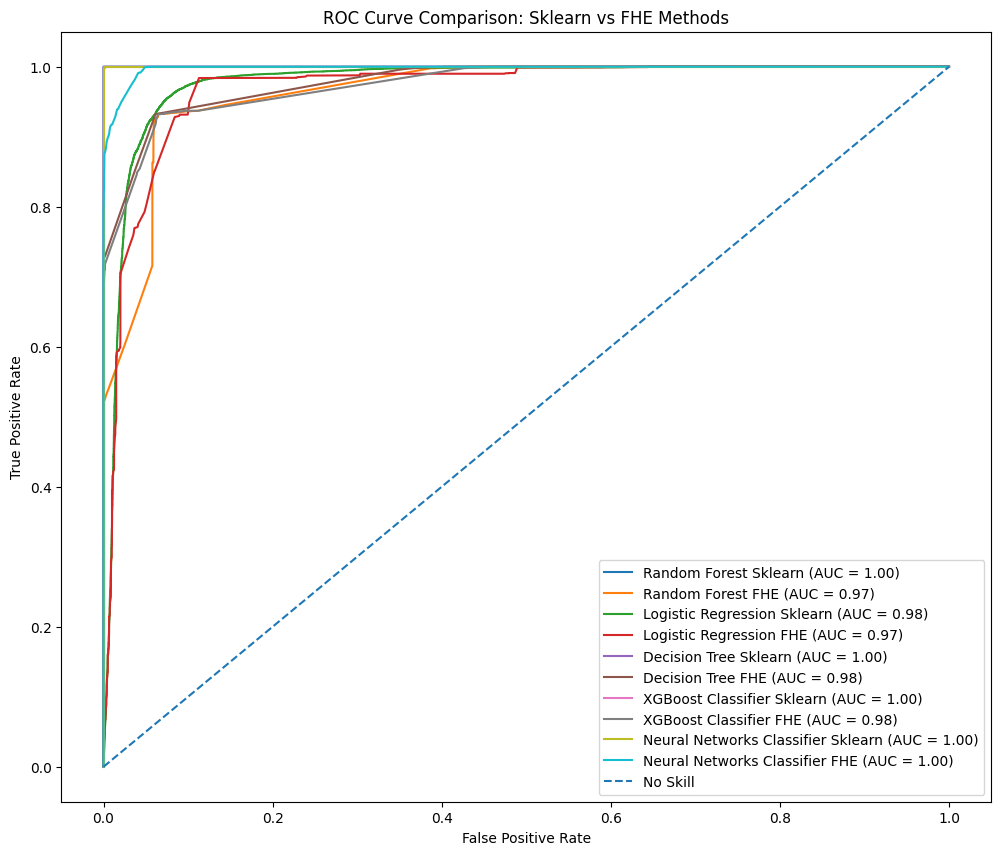

In [19]:
def plot_roc_curves(val_data, val_labels, models_list):
    """
    Plot ROC Curves
    """
    plt.figure(figsize=(12, 10))
    for model_name, (sk_model, fhe_model) in models_list.items():
        if hasattr(sk_model, "predict_proba") and model_name != "K-Nearest Neighbors":
            sk_y_pred_proba = sk_model.predict_proba(val_data)[:, 1]
            fhe_y_pred_proba = fhe_model.predict_proba(val_data)[:, 1]

            sk_fpr, sk_tpr, _ = roc_curve(val_labels, sk_y_pred_proba)
            fhe_fpr, fhe_tpr, _ = roc_curve(val_labels, fhe_y_pred_proba)

            sk_roc_auc = auc(sk_fpr, sk_tpr)
            fhe_roc_auc = auc(fhe_fpr, fhe_tpr)

            plt.plot(
                sk_fpr, sk_tpr, label=f"{model_name} Sklearn (AUC = {sk_roc_auc:.2f})"
            )
            plt.plot(
                fhe_fpr, fhe_tpr, label=f"{model_name} FHE (AUC = {fhe_roc_auc:.2f})"
            )

    plt.plot([0, 1], [0, 1], linestyle="--", label="No Skill")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve Comparison: Sklearn vs FHE Methods")
    plt.legend(loc="lower right")
    plt.show()


plot_roc_curves(x_val_scaled, y_val, models)

## Grid Search

In [20]:
param_grid = {
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "criterion": ["gini", "entropy"],
}

sk_dt = SkDecisionTreeClassifier(random_state=42)
fhe_dt = DecisionTreeClassifier(random_state=42)

grid_search_sk = GridSearchCV(
    estimator=sk_dt, param_grid=param_grid, cv=3, n_jobs=-1, scoring="accuracy"
)

y_train = y_train.astype(int)
y_val = y_val.astype(int)

grid_search_sk.fit(x_train_scaled, y_train)

grid_search_fhe = GridSearchCV(
    estimator=fhe_dt, param_grid=param_grid, cv=3, n_jobs=-1, scoring="accuracy"
)

grid_search_fhe.fit(x_train_scaled, y_train)

results_sk = pd.DataFrame(grid_search_sk.cv_results_)
results_fhe = pd.DataFrame(grid_search_fhe.cv_results_)

results_sk = results_sk[["params", "mean_test_score"]]
results_fhe = results_fhe[["params", "mean_test_score"]]

results_sk.rename({"mean_test_score": "Sklearn Accuracy"}, inplace=True)
results_fhe.rename({"mean_test_score": "Concrete ML Accuracy"}, inplace=True)

params_sk = results_sk["params"].apply(pd.Series)
params_fhe = results_fhe["params"].apply(pd.Series)

results_sk = pd.concat([params_sk, results_sk.drop(columns="params")], axis=1)
results_fhe = pd.concat([params_fhe, results_fhe.drop(columns="params")], axis=1)

results_combined = pd.merge(
    results_sk, results_fhe, on=list(params_sk.columns), how="outer"
)

In [21]:
display(results_combined)

,criterion,max_depth,min_samples_leaf,min_samples_split,mean_test_score_x,mean_test_score_y
0,gini,NaN,1,2,0.999893,0.945949
1,gini,NaN,1,5,0.999893,0.946002
2,gini,NaN,1,10,0.999875,0.945967
3,gini,NaN,2,2,0.999839,0.945922
4,gini,NaN,2,5,0.999839,0.945949
...,...,...,...,...,...,...
67,entropy,30.0,2,5,0.999848,0.946002
68,entropy,30.0,2,10,0.999857,0.946074
69,entropy,30.0,4,2,0.999839,0.945993
70,entropy,30.0,4,5,0.999839,0.945993


In [22]:
best_params_sk = grid_search_sk.best_params_
best_sk_dt = SkDecisionTreeClassifier(**best_params_sk, random_state=42)
best_sk_dt.fit(x_train_scaled, y_train)

joblib.dump(best_sk_dt, "best_sklearn_model.pkl")

['best_sklearn_model.pkl']

In [23]:
best_params_fhe = grid_search_fhe.best_params_
best_fhe_dt = DecisionTreeClassifier(**best_params_fhe, random_state=42)
best_fhe_dt.fit(x_train_scaled, y_train)
best_fhe_dt.compile(x_train_scaled)

In [24]:
fhe_directory = os.path.join(os.path.abspath(os.getcwd()), "fhe_file")
if os.path.exists(fhe_directory):
    shutil.rmtree(fhe_directory)
os.makedirs(fhe_directory)
dev = FHEModelDev(path_dir=fhe_directory, model=best_fhe_dt)
dev.save()

## Testing our model on the basic unbalanced data from the dataset

In [25]:
train_indices = x_train.index
all_test_indices = df.index.difference(train_indices)
X_all_test = df.loc[all_test_indices].drop(columns=["fraud"])
y_all_test = df.loc[all_test_indices]["fraud"]
X_all_test_scaled = scaler.fit_transform(X_all_test)


y_val = y_val.astype(int)
y_all_test = y_all_test.astype(int)

results_all_data = []
pred_balanced_data = best_sk_dt.predict(x_val_scaled)
balanced_data_accuracy = accuracy_score(y_val, pred_balanced_data)

pred_initial_data = best_sk_dt.predict(X_all_test_scaled)
initial_data_accuracy = accuracy_score(y_all_test, pred_initial_data)

results_all_data = [
    {
        "Balanced Data Accuracy": balanced_data_accuracy,
        "Initial Data Accuracy": initial_data_accuracy,
    }
]
results_all_data_df = pd.DataFrame(results_all_data)
display(results_all_data_df)

,Balanced Data Accuracy,Initial Data Accuracy
0,0.999928,0.835676
